In [1]:
import torch
from chapter_04 import GPTModel


GPT_CONFIG_124M = {
    "vocab_size": 50257,

    "context_length": 256,
    "emb_dim": 768,
    "n_heads": 12,
    "n_layers": 12,
    "drop_rate": 0.1,
    "qkv_bias": False
}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
model.eval()

/home/mat/anaconda3/envs/whisper_triton/lib/python3.8/site-packages/torch/cuda/__init__.py:128: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

In [2]:
import os
import urllib.request

file_path = "the-verdict.txt"

url = (
    "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/"
    "main/ch02/01_main-chapter-code/the-verdict.txt"
)

if not os.path.exists(file_path):
    with urllib.request.urlopen(url) as response:
        text_data = response.read().decode('utf-8')
    with open(file_path, "w", encoding="utf-8") as file:
        file.write(text_data)
else:
    with open(file_path, "r", encoding="utf-8") as file:
        text_data = file.read()

In [6]:
# from previous_chapters import create_dataloader_v1
from torch.utils.data import DataLoader

train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))
torch.manual_seed(123)
train_loader = DataLoader(
    text_data[:split_idx],
    batch_size=2,
    # max_length=GPT_CONFIG_124M["context_length"],
    # stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)
val_loader = DataLoader(
    text_data[split_idx:],
    batch_size=2,
    # max_length=GPT_CONFIG_124M["context_length"],
    # stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)

# Learning rate warmup

It can stabilize the training of complex models such as LLMs. This model involves gradually increasing the learning rate from a very low initial value (`initial_lr`) to a maximum value specified by the user (`peak_lr`).
Starting the training with smaller weight updates decrease the risk of the model encountering large, destabilizing updates during its training phase



In [7]:
n_epochs = 15
initial_lr = 0.0001
peak_lr = 0.01
warmup_steps = 20

In [8]:
total_steps = len(train_loader) * n_epochs
warmup_steps = int(0.2 * total_steps)
print(warmup_steps)

27645


In [9]:
optimizer = torch.optim.AdamW(model.parameters(), weight_decay=0.1)
lr_increment = (peak_lr - initial_lr) / warmup_steps

global_step = -1
track_lrs = []

for epoch in range(n_epochs):
    for input_batch, target_batch in train_loader:
        optimizer.zero_grad()
        global_step += 1

        if global_step < warmup_steps:
            lr = initial_lr + global_step * lr_increment
        else:
            lr = peak_lr

        for param_group in optimizer.param_groups:
            param_group["lr"] = lr
        track_lrs.append(optimizer.param_groups[0]["lr"])

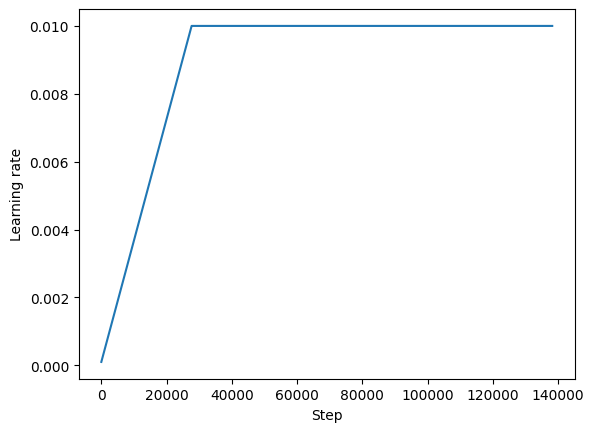

In [10]:
import matplotlib.pyplot as plt

plt.ylabel("Learning rate")
plt.xlabel("Step")
total_training_steps = len(train_loader) * n_epochs
plt.plot(range(total_training_steps), track_lrs);
plt.show()

# Cosine decay

This method modulates the learning rate throughout the training epochs, making it follow a cosine curve after the warmup stage.

In its popular variant, cosine decay reduces the learning rate to nearly zero, mimicking the trajectory of a half-cosine cycle.
